In [1]:
from datautils import get_dls
from src.models.resnet import ResNet
from src.learner import  transfer_weights
from torchinfo import summary
import torch.nn as nn
from src.basics import set_device
import torch

set_device()

class params:
    def __init__(self, **kwargs):
        for key in kwargs:
            setattr(self, key, kwargs[key])

In [2]:
dls = get_dls(params(batch_size=1, dset='gunpoint', num_workers=1)) 

In [3]:
model = ResNet(1, 'classification', 2, .2)

In [4]:
w_path = 'saved_models/gunpoint/resnet/based_model/resnet_cw150_epochs-pretrain20_model1.pth'
model = transfer_weights(weights_path=w_path, model=model, exclude_head=False, device='cuda')

weights from saved_models/gunpoint/resnet/based_model/resnet_cw150_epochs-pretrain20_model1.pth successfully transferred!



In [5]:
model.eval()

ResNet(
  (block1): ResNetBlock(
    (conv1): Conv1d(1, 64, kernel_size=(8,), stride=(1,), padding=same, bias=False)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=same, bias=False)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv1d(1, 64, kernel_size=(1,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (block2): ResNetBlock(
    (conv1): Conv1d(64, 128, kernel_size=(8,), stride=(1,), padding=same, bias=False)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(128, 1

In [71]:
from scipy.spatial.distance import pdist, cdist, squareform

In [24]:
class GAP_Resnet(nn.Module):

    def __init__(self, model):
        super(GAP_Resnet, self).__init__()

        self.model = nn.Sequential(model.block1, model.block2, model.block3, model.gap)

    def forward(self, x):
        x = x.permute(0,2,1)
        out = self.model(x)
        return out

In [25]:
gap_m = GAP_Resnet(model)

In [26]:
dl = iter(dls.train)


In [27]:
X, y = next(dl)

In [28]:
X = X.unsqueeze(-1)

In [29]:
X.shape

torch.Size([1, 150, 1])

In [32]:
gap_m(X.cuda()).shape

torch.Size([1, 128])

In [90]:
N = 50
X = []
X_GAP = []
Y = []
for _ in range(N):
    x, y = next(dl)
    x = x.unsqueeze(-1)
    X.append(x)
    Y.append(y)
    X_GAP.append(gap_m(x.cuda()))





In [91]:
def to_numpy(l):
    return [el.detach().cpu().numpy( ) for el in l ]

In [92]:
X_GAP = to_numpy(X_GAP)

In [93]:
Y = to_numpy(Y)
X = to_numpy(X)

In [94]:
import numpy as np

In [95]:
X = np.array(X)
X_GAP = np.array(X_GAP)

In [102]:
X = X.reshape(N,150)
X_GAP = X_GAP.reshape(N,128)

In [103]:
Xdist = squareform(pdist(X))

In [104]:
X_GAP_dist = squareform(pdist(X_GAP))

In [105]:
def stress(Xdist, X_GAP_dist):
    d_norm = np.sum(X_GAP_dist**2)
    up = np.sum((X_GAP_dist-Xdist)**2)
    return np.sqrt(up/d_norm)

In [106]:
stress(Xdist, X_GAP_dist)

0.5678418911692323

In [107]:
from sklearn.manifold import MDS

mds_gap = MDS(dissimilarity='precomputed', random_state=0)
X_transform = mds.fit_transform(X_GAP_dist)

In [108]:
import matplotlib.pyplot as plt

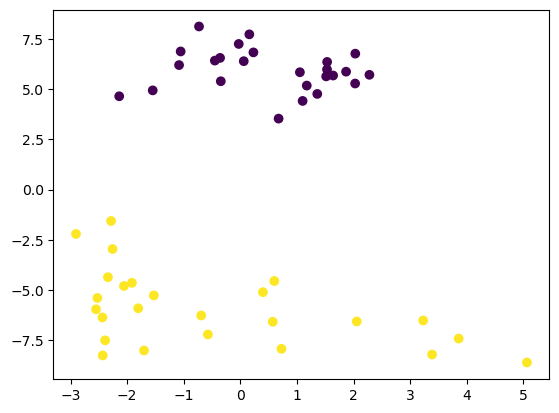

In [109]:
plt.scatter(X_transform[:,0], X_transform[:,1], c=np.ravel(Y))
plt.show()

In [110]:
mds_raw = MDS(random_state=0)
X_transform = mds_raw.fit_transform(X)

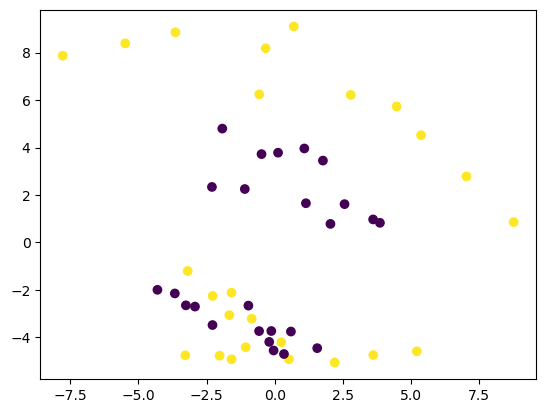

In [111]:
plt.scatter(X_transform[:,0], X_transform[:,1], c=np.ravel(Y))
plt.show()